
### Imports

Let's start by importing the modules we'll need below. The main one is the ```PolyBin``` package, as well as ```Healpy``` for visualization / mask loading.

In [1]:
%pylab inline
import polybin as pb
import healpy
from classy import Class

Populating the interactive namespace from numpy and matplotlib


# 1. Set-Up

### Options

Below, we'll set all the user-defined options we will need. These include the map resolution, the number of simulations used, the binning, and the input mask.

In [2]:
# HEALPix settings
Nside = 128
lmax = 3*Nside-1

# Bin edges (could also be non-linearly spaced)
l_bins = np.arange(5,205,5)
Nl = len(l_bins)-1
print("binned lmax: %d, HEALPix lmax: %d"%(np.max(l_bins),lmax))
assert lmax>np.max(l_bins)

# Number of random iterations to create Fisher matrix
N_it = 10 # N ~ 100 is sufficient in practice, we'll use 10 for testing

# Number of simulations to use for testing
N_sim = 50

# Whether to include bins only partially satisfying triangle conditions
include_partial_triangles = False

# separable reduced bispectrum (added to the input maps in Sec. III)
b_input_fac = lambda l1: np.exp(-(l1-2)/40.)*2e-6

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

binned lmax: 200, HEALPix lmax: 383


### Fiducial Power and Noise Spectrum

Below, we define a fiducial power and noise spectrum that we'll use to generate the testing simulations, and to weight the data. Here, we'll take them from the Planck 2018 cosmology, using CLASS.

In [3]:
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))*(l>2)

### Load mask

For testing, we use a *Planck* 40\% sky mask with 2-degree apodization applied.

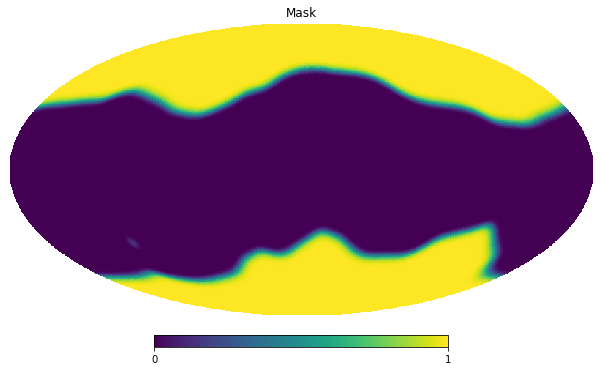

In [4]:
mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
healpy.mollview(mask,title='Mask')

### Initialize PolyBin class

Let's start by calling the main PolyBin class. This contains a bunch of useful methods, including spherical harmonic transforms (via HEALPix) and code to generate random simulations. We can optionally add an experimental beam here too (note that the input data is *not* expected to be beam-deconvolved, but the output spectra will be).

In [5]:
# Load class with fiducial signal+noise, beam, and Nside
beam = 1.+0.*l
Sl_fiducial =  beam**2*Cl_th+Nl_th+Cl_th[2]*(l<2) # avoiding zeros at l<2
base = pb.PolyBin(Nside,Sl_fiducial,beam)

Next, we'll create some synthetic data with a known $C_\ell$. We can optionally add a bispectrum term: for simplicity, we use a factorized form with $b_{\ell_1\ell_2\ell_3}=\beta_{\ell_1}\beta_{\ell_2}\beta_{\ell_3}$ where $\beta$ was defined above. We will window this data with the *Planck* map.

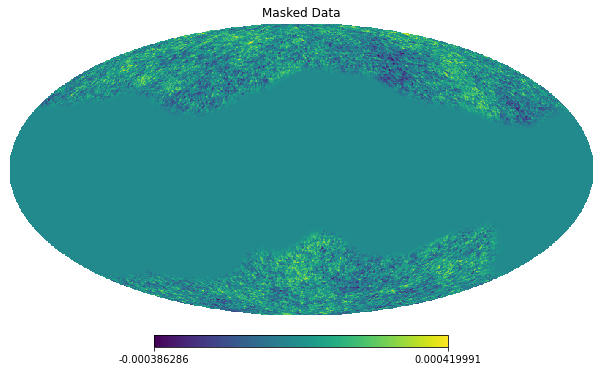

In [6]:
# Generate unmasked data with known C_l and factorized b
# Cl is set to the fiducial spectrum unless otherwise specified
# No beam is included
raw_data = base.generate_data(seed=42, add_B=False)

# Mask the map
data = raw_data*mask

# Plot the data
healpy.mollview(data,title='Masked Data')

### Define weighting function
A crucial input to the unwindowed estimators is a function, $\mathsf{S}^{-1}$, which provides quasi-optimal weighting to the data. A simple option would be ```applySinv=base.applyUinv```, which matches the code below. To form a fully optimal estimator, $\mathsf{S}^{-1}$ should be equal to the true data covariance $\tilde{\mathsf{C}}_{\rm fid}$ (which includes noise); in practice, it is usually sufficient to employ a diagonal weighting scheme.

In [7]:
def applySinv(input_map):
    """Apply the quasi-optimal weighting, S^{-1} to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular C_l, and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = base.to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = base.to_map(base.safe_divide(input_map_lm,base.Cl_lm))
    
    return Cinv_map

For complex masks, an alternative approach is to use a non-square weighting $\mathsf{S}^{-1}$ which projects out holes and poorly reproduced areas in the map. Below, we give an exemplar choice, matching that used in the Planck parity-odd trispectrum analysis. This employs both an inpainting mask and a smoothed non-invertible mask.

When using a $\mathsf{S}^{-1}$ filter like the below, one should *not* include the mask in the ```pspec```, ```bspec``` and ```tspec``` code below, since it has already been accounted for in the weighting.

In [8]:
########################### WEIGHTING ###########################

inpainting_map = 0.*mask # for testing
smooth_mask = mask.copy() # combination of regular + inpainting mask

def inpaint_map(input_map):
    """
    Apply linear inpainting to a map, given an inpainting mask
    """
    
    tmp_map = input_map.copy()
    
    # Zero out inpainting regions 
    tmp_map[inpainting_mask==1] = 0 

    # Perform iterative impainting
    for i in range(1000):

        inpaint_pix = np.where((tmp_map==0)&(inpainting_mask==1))[0]
        if len(inpaint_pix)==0:
            break
        # Identify four nearest neighbors
        neighbors = healpy.get_interp_weights(Nside,inpaint_pix)[0]
        tmp_map[inpaint_pix] = np.mean(tmp_map[neighbors],axis=0)

    return tmp_map

def applySinv_planck(input_map):
    """
    Apply the quasi-optimal weighting, S^{-1} to a map. This firstly inpaints small holes in the data, applies a smooth mask, then weights by an ell-dependent factor.
    
    Note that this is neither diagonal nor invertible. The weighting is given by Cl_lm = B_l^2 C_l^TT + N_l here for beam B_l.
    """
    ## Step 1: inpaint the data
    tmp_map = inpaint_map(input_map)
    
    ## Step 2: mask out the large bad regions
    tmp_map *= smooth_mask
        
    ## Step 3: Apply S+N weighting in harmonic space
    Cinv_map = base.to_map(base.safe_divide(base.to_lm(tmp_map),base.Cl_lm))
    
    return Cinv_map

# 2. Power Spectrum Estimation

Let's compute the binned power spectrum of the map, using both the idealized and optimal estimators. The unwindowed estimator requires a Fisher matrix which we can compute via multiprocessing. Note that the Fisher matrix is independent of the data, thus only needs to be computed once per mask / binning choice.

In [9]:
# Initialize power spectrum class
# NB: use mask = 1.+0.*mask if including mask projection in S^-1 (as in applySinv_planck)
pspec = pb.PSpec(base, mask, applySinv, l_bins)

Binning: 39 bins in [5, 200]


### Ideal Estimator

We'll begin by computing the (standard) idealized power spectrum estimator. This is straightforward to do, and involves only one harmonic transform (plus some $\ell$-space summations).

In [10]:
# Compute idealized power spectrum
Cl_ideal = pspec.Cl_ideal(data)

Computing ideal Fisher matrix


In [11]:
# Define centers of l bins
ls = np.asarray(pspec.get_ells())

# Print out a few bin centers:
for i in range(5):
    print("Bin %d: l = %.1f"%(i,ls[i]))

Bin 0: l = 7.5
Bin 1: l = 12.5
Bin 2: l = 17.5
Bin 3: l = 22.5
Bin 4: l = 27.5


### Unwindowed Estimator

For the unwindowed estimator, we'll first compute the Fisher matrix, then use this to compute the full unwindowed estimator.

In [12]:
# Compute Fisher matrix on 4 CPUs
fish = pspec.compute_fisher(N_it, N_cpus=4);

# Compute unwindowed power spectrum
Cl_opt = pspec.Cl_unwindowed(data, fish=fish)

Computing Fisher contribution from 10 Monte Carlo simulations on 4 threads


100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


Alternatively, we can assemble the Fisher matrix by hand (e.g., if we wish to distribute between many nodes). Then we just need to pass it to the estimator.

In [13]:
# # Iterate by hand
# fish = 0.
# for i in range(N_it):
#     if i%5==0: print("On iteration %d of %d"%(i+1,N_it))
#     fish += pspec.compute_fisher_contribution(i)/N_it

# # Compute unwindowed power spectrum, passing the Fisher matrix
# Cl_opt = pspec.Cl_unwindowed(data, fish=fish)

Let's plot the results! We note that the final bin or two of the optimal estimator could be biased since we ignore the correlations with the higher bins. These would be excluded in any real analysis.

We also plot the Fisher matrix, which shows how correlated individual bins are as a result of the window.

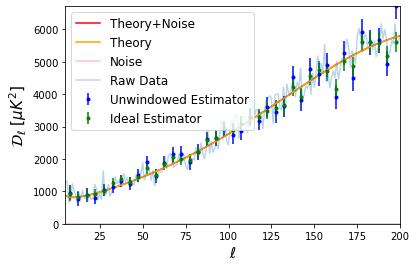

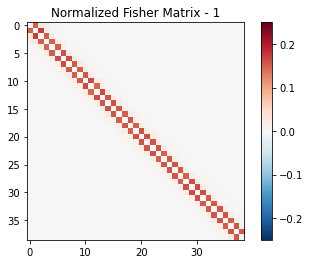

In [14]:
l_av = 0.5*(l_bins[1:]+l_bins[:-1])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12
pref = l*(l+1)/(2.*np.pi)*1e12

fish_err = np.sqrt(np.diag(pspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal))*np.sqrt(np.mean(mask**4.)/np.mean(mask**2)**2)

# Compute the HEALPix unbinned pseudo-Cl power spectrum, for comparison
Cl_raw_healpy = healpy.alm2cl(base.safe_divide(base.to_lm(raw_data),base.beam_lm))

# Plot spectra
plt.errorbar(l_av,pref_av*Cl_opt,yerr=pref_av*fish_err,marker='.',ls='',label='Unwindowed Estimator',c='b')
plt.errorbar(l_av,pref_av*Cl_ideal,yerr=pref_av*fish_err_ideal,marker='.',ls='',label='Ideal Estimator',c='g')
plt.plot(l,pref*(Cl_th+Nl_th/(1e-12+beam**2)),label='Theory+Noise',c='r')
plt.plot(l,pref*(Cl_th),label='Theory',c='orange')
plt.plot(l,pref*(Nl_th/(1e-12+beam**2)),label='Noise',c='pink')
plt.plot(l,pref*Cl_raw_healpy,label='Raw Data',alpha=0.3)
plt.xlim([min(l_bins),max(l_bins)])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0,max(pref_av*Cl_opt)])

# Plot correlation matrix
plt.figure()
corr_fish = fish/np.sqrt(np.outer(np.diag(fish),np.diag(fish)))
v = 0.25
plt.imshow(corr_fish-np.eye(len(corr_fish)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Normalized Fisher Matrix - 1")
plt.colorbar();

### Iterate over multiple data-sets
We can test whether the estimator is (close-to) minimum variance by iterating over GRF datasets. This is fast, since we don't need to recompute the Fisher matrix!

In [15]:
Cl_unwindowed_all = []
Cl_ideal_all = []
Cl_raw_all = []

for ii in range(N_sim):
    if ii%10==0: 
        print("Analyzing simulation %d of %d"%(ii+1,N_sim))
    
    # Generate data (pure GRFs here)
    raw_sim = base.generate_data(ii,add_B=False)
    sim = mask*raw_sim
    
    # Compute binned and unbinned power spectra
    Cl_unwindowed_all.append(pspec.Cl_unwindowed(sim))
    Cl_ideal_all.append(pspec.Cl_ideal(sim))
    raw_sim_lm = base.safe_divide(healpy.map2alm(raw_sim),pspec.base.beam_lm)
    Cl_raw_all.append(healpy.alm2cl(raw_sim_lm))

Analyzing simulation 1 of 50
Analyzing simulation 11 of 50
Analyzing simulation 21 of 50
Analyzing simulation 31 of 50
Analyzing simulation 41 of 50


Below, we plot the results. Importantly, the variance of the unwindowed estimator matches its Fisher matrix - i.e. it is roughly optimal! (Note that perfect optimality is only guaranteed if we use optimal weights).

However, it looks like the idealized estimator has a *lower* variance? This is due to the off-diagonal correlations imposed by the window function, as seen in the correlation matrices.

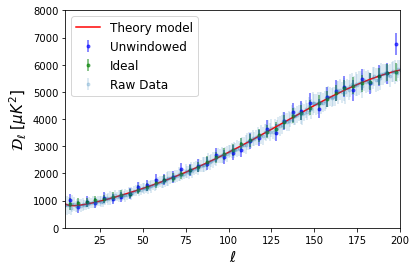

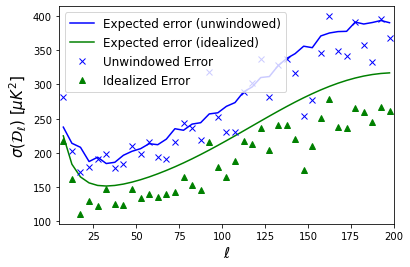

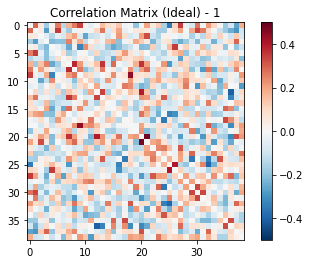

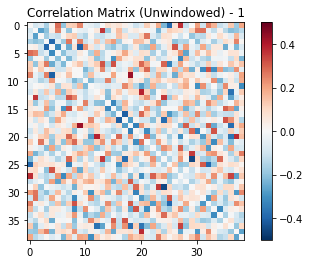

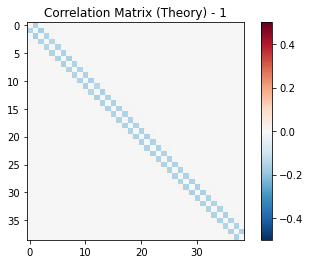

In [16]:
fish_err = np.sqrt(np.diag(pspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(pspec.inv_fish_ideal))*np.sqrt(np.mean(mask**4)/np.mean(mask**2)**2)
plt.errorbar(l_av,pref_av*np.asarray(Cl_unwindowed_all).mean(axis=0),yerr=pref_av*fish_err,marker='.',ls='',label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(l_av,pref_av*np.asarray(Cl_ideal_all).mean(axis=0),yerr=pref_av*fish_err_ideal,marker='.',ls='',label='Ideal',c='g',alpha=0.6)
plt.plot(l,pref*(Cl_th+Nl_th/beam**2),label='Theory model',c='r')
plt.errorbar(l,pref*np.asarray(Cl_raw_all).mean(axis=0),yerr=pref*np.asarray(Cl_raw_all).std(axis=0),
             ls='',marker='.',label='Raw Data',alpha=0.2)
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0,8000])
plt.xlim([np.min(l_bins),np.max(l_bins)])

plt.figure()
plt.plot(l_av,pref_av*fish_err,label='Expected error (unwindowed)',c='b')
plt.plot(l_av,pref_av*fish_err_ideal,label='Expected error (idealized)',c='g')
plt.plot(l_av,pref_av*np.asarray(Cl_unwindowed_all).std(axis=0),label='Unwindowed Error',c='b',marker='x',ls='')
plt.plot(l_av,pref_av*np.asarray(Cl_ideal_all).std(axis=0),label='Idealized Error',c='g',marker='^',ls='')
plt.xlabel(r'$\ell$',fontsize=15)
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\mathcal{D}_\ell)\,\,[\mu K^2]$',fontsize=15);
plt.xlim([np.min(l_bins),np.max(l_bins)])

# Plot correlation matrices
cov_ideal = np.cov(np.asarray(Cl_ideal_all).T)
corr_ideal = cov_ideal/np.sqrt(np.outer(np.diag(cov_ideal),np.diag(cov_ideal)))
cov_unwindowed = np.cov(np.asarray(Cl_unwindowed_all).T)
corr_unwindowed = cov_unwindowed/np.sqrt(np.outer(np.diag(cov_unwindowed),np.diag(cov_unwindowed)))
cov_theory = np.linalg.inv(pspec.fish)
corr_theory = cov_theory/np.sqrt(np.outer(np.diag(cov_theory),np.diag(cov_theory)))

plt.figure()
v = 0.5
plt.imshow(corr_ideal-np.eye(len(corr_ideal)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Ideal) - 1")
plt.colorbar();

plt.figure()
plt.imshow(corr_unwindowed-np.eye(len(corr_unwindowed)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Unwindowed) - 1")
plt.colorbar();

plt.figure()
plt.imshow(corr_theory-np.eye(len(corr_theory)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation Matrix (Theory) - 1")
plt.colorbar();

# 3. Bispectrum estimation

We now move to estimating the bispectrum, both via idealized and window-free estimators. As before, we will need to compute a Fisher matrix, depending on the survey geometry. To avoid the dimensionality (and run-time) getting out of hand, we will use a broad binning for this exercise, noting that bispectra are much more computationally expensive than power spectra! In practice, one would usually run the Fisher matrix on a cluster rather than on a laptop.

In [17]:
## Binning parameters
# Note that we can use separate binning for squeezed triangles
l_bins = np.arange(5,65,10)
l_bins_squeeze = np.arange(5,75,10)

In [18]:
# Initialize bispectrum class
bspec = pb.BSpec(base, mask, applySinv, l_bins,l_bins_squeeze=l_bins_squeeze)

Binning: 5 bins in [5, 55]
Squeezed binning: 6 bins in [5, 65]


In [19]:
# Compute centers of l1, l2, l3 bins
l1s,l2s,l3s = np.asarray(bspec.get_ells())

# Print out a few bin centers:
for i in range(5):
    print("Bin %d: l1 = %.1f, l2 = %.1f, l3 = %.1f"%(i,l1s[i],l2s[i],l3s[i]))

Bin 0: l1 = 10.0, l2 = 10.0, l3 = 10.0
Bin 1: l1 = 10.0, l2 = 10.0, l3 = 20.0
Bin 2: l1 = 10.0, l2 = 20.0, l3 = 20.0
Bin 3: l1 = 10.0, l2 = 20.0, l3 = 30.0
Bin 4: l1 = 10.0, l2 = 30.0, l3 = 30.0


### Ideal Estimator

Let's start by computing the ideal bispectrum. This is a little more expensive than before, requiring $\mathcal{O}(N_{\rm bin})$ harmonic transforms. This function computes the normalization internally via a sum over Wigner matrices involving $\ell_1,\ell_2,\ell_3$. We'll also recompute the data, now including a primordial bispectrum.

In [20]:
# Compute data
data = mask*base.generate_data(seed=42, add_B=True, b_input=b_input_fac)

# Compute ideal bispectra
b_ideal = bspec.Bl_ideal(data)

Computing offset for synthetic maps
Computing ideal Fisher matrix
Using 42 bispectrum bins


### Window-free estimator
The window-free estimator can be computed similarly to the bispectrum, and involves a Fisher matrix that can be computed internally or externally.

We also require a set of simulations to form the linear term in the bispectrum estimator (i.e. that involving $a\langle{aa\rangle}$). These can be generated by the code (as GRFs, optionally with an added factorizable bispectrum), or read-in from some external source. These should have the same covariance as the data (but do not need to have accurate higher-order statistics). 

In [21]:
# Generate MC simulations for estimator numerator
bspec.generate_sims(N_it,b_input=b_input_fac,add_B=True,remove_mean=True)

# # Alternatively, read-in MC simulations created externally
# alpha_sims = []
# for ii in range(N_it):
#     alpha = base.generate_data(seed=10000+ii,add_B=include_synthetic_b, b_input=b_input_fac)
#     alpha_sims.append(alpha)
# bspec.load_sims(alpha_sims, verb=True)

# Compute the Fisher matrix, via multiprocessing
fish = bspec.compute_fisher(N_it, N_cpus=4)

# Compute the unwindowed estimator, optionally removing the linear term
b_unwindowed = bspec.Bl_unwindowed(data, verb=True, include_linear_term=True)

Using 10 Monte Carlo simulations
Computing Fisher contribution from 10 pairs of Monte Carlo simulations on 4 threads


100%|██████████| 10/10 [02:47<00:00, 16.71s/it]


Computing b_3 piece
Computing b_1 piece from simulation 5
Computing b_1 piece from simulation 10


As before, we can compute the Fisher matrix externally (e.g., on a cluster) and read it in.

In [22]:
# # Iterate by hand
# fish = 0.
# for i in range(N_it):
#     if i%5==0: print("On iteration %d of %d"%(i+1,N_it))
#     fish += bspec.compute_fisher_contribution(i, verb=(i==0))/N_it

# # Compute unwindowed estimator, passing the Fisher matrix
# b_unwindowed = bspec.Bl_unwindowed(data, verb=True, fish=fish, include_linear_term=True)

Now let's plot the results!

Bispectra are harder to plot than power spectra, due to their higher dimensionality. Here, we'll just stack all the data into one dimension. This starts with $b_1=b_2=b_3=1$, then updates each bin in turn, starting with $b_3$ and selecting only bins satisfying the triangle condition.

Below, we'll compare the results from the two estimators as well as the theory model. We'll also consider the Fisher matrix. Notably, we can see non-trivial off-diagonal correlations imparted by the survey geometry.

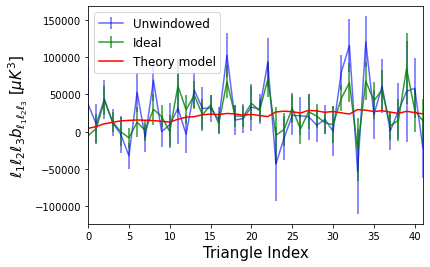

In [23]:
fish_err = np.sqrt(np.diag(np.linalg.inv(bspec.fish)))
weights = l1s*l2s*l3s*1e18
bl_model = b_input_fac(l1s)*b_input_fac(l2s)*b_input_fac(l3s)

fish_err_ideal = np.sqrt(np.diag(np.linalg.inv(bspec.fish_ideal))*np.mean(mask**6.)/np.mean(mask**3)**2)
plt.errorbar(np.arange(bspec.N_b),weights*b_unwindowed,yerr=weights*fish_err,label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(np.arange(bspec.N_b),weights*b_ideal,yerr=weights*fish_err_ideal,label='Ideal',c='g',alpha=0.8)
plt.errorbar(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
plt.legend(fontsize=12)
plt.xlim([0,bspec.N_b-1])
plt.xlabel("Triangle Index",fontsize=15)
plt.ylabel(r"$\ell_1\ell_2\ell_3 b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$",fontsize=15);

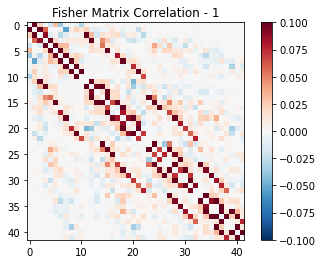

In [24]:
corr_fish_b = bspec.fish/np.sqrt(np.outer(np.diag(bspec.fish),np.diag(bspec.fish)))
v = 0.1
plt.imshow(corr_fish_b-np.eye(len(corr_fish_b)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Fisher Matrix Correlation - 1")
plt.colorbar();

### Iterate over multiple datasets

To test the estimators, we can compute the variance from a suite of mock datasets, as for the power spectrum. This is comparatively cheap, since we have already loaded the Monte Carlo simulations (for the linear term) and the Fisher matrix.

In [25]:
b_unwindowed_all = []
b_ideal_all = []

for jj in range(N_sim):
    
    if jj%10==0: 
        print("Analyzing simulation %d of %d"%(jj+1,N_sim))

    # Generate unmasked data
    data = mask*base.generate_data(jj,add_B=True, b_input=b_input_fac)

    b_ideal_all.append(bspec.Bl_ideal(data))
    b_unwindowed_all.append(bspec.Bl_unwindowed(data,verb=False))

Analyzing simulation 1 of 50
Analyzing simulation 11 of 50
Analyzing simulation 21 of 50
Analyzing simulation 31 of 50
Analyzing simulation 41 of 50


Below, we plot the results and consider the errors. Once again, the variance is very close to the Fisher matrix prediction, i.e. we are close to optimal!

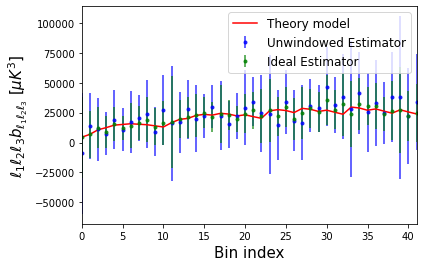

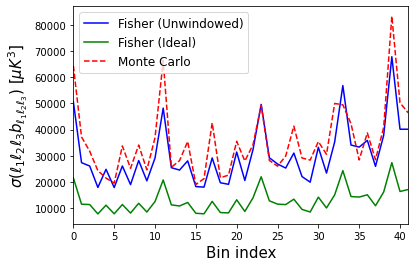

In [26]:
fish_err = np.sqrt(np.diag(bspec.inv_fish))
fish_err_ideal = np.sqrt(np.diag(bspec.inv_fish_ideal))

plt.errorbar(np.arange(bspec.N_b),weights*np.asarray(b_unwindowed_all).mean(axis=0),yerr=weights*fish_err,marker='.',ls='',label='Unwindowed Estimator',c='b',alpha=0.8)
plt.plot(np.arange(bspec.N_b),weights*bl_model,label='Theory model',c='r')
plt.errorbar(np.arange(bspec.N_b),weights*np.asarray(b_ideal_all).mean(axis=0),yerr=weights*np.asarray(b_ideal_all).std(axis=0),
             ls='',marker='.',label='Ideal Estimator',alpha=0.8,c='g')
plt.xlim([0,bspec.N_b-1])
plt.xlabel(r'Bin index',fontsize=15)
plt.ylabel(r'$\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3}\,\,[\mu K^3]$',fontsize=15)
plt.legend(fontsize=12)

plt.figure()
plt.plot(np.arange(bspec.N_b),weights*fish_err,label='Fisher (Unwindowed)',c='b')
plt.plot(np.arange(bspec.N_b),weights*fish_err_ideal,label=r'Fisher (Ideal)',c='g')
plt.plot(np.arange(bspec.N_b),weights*np.asarray(b_unwindowed_all).std(axis=0),label='Monte Carlo',c='r',ls='--')
plt.xlabel(r'Bin index',fontsize=15)
plt.xlim([0,bspec.N_b-1])
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\ell_1\ell_2\ell_3b_{\ell_1\ell_2\ell_3})\,\,[\mu K^3]$',fontsize=15);

# 4. Trispectrum Estimation

Finally, we consider the trispectrum. This is computed in a similar way to before, but there are a few key differences: one is that we can estimate both a *parity-even* and *parity-odd* trispectrum. (The parity-odd parts of an isotropic scalar field are trivially zero for the lower-point functions).

Since trispectrum estimation is considerably more expensive than power spectrum or bispectrum estimation, we'll use a broader binning here and low $\ell_{\rm max}$. In general, calculations would be performed on a cluster, but we'll pick a small problem below for testing on a single computer.

In [27]:
# Initialize trispectrum class and pick binning
l_bins_raw = np.arange(5,55,10)
# We could also use a non-linear binning: the scaling of the option below gives roughly equal (S/N)^2 per bin
# l_bins_raw = np.asarray(5+np.arange(0,70**0.4,2**0.4)**2.5,dtype='int')

# Let's also use slightly lower l_max for collapsed and unsqueezed configurations
l_bins_squeeze = l_bins_raw.copy()
L_bins = l_bins_raw.copy()[:-2]
l_bins = l_bins_raw.copy()[:-1]

In [28]:
tspec = pb.TSpec(base, mask, applySinv, l_bins, l_bins_squeeze=l_bins_squeeze, L_bins=L_bins)

Binning: 3 bins in [5, 35]
Squeezed binning: 4 bins in [5, 45]
L binning: 2 bins in [5, 25]


In [29]:
# Define centers of l1, l2, l3, l4, L bins
l1s,l2s,l3s,l4s,Ls,parities = tspec.get_ells()
print("Using %d bins in total"%len(l1s))

# Print out a few bin centers:
for i in range(10):
    print("Bin %d: l1 = %d, l2 = %d,l3 = %d, l4=%d, L=%d, parity = %s"%(i,l1s[i],l2s[i],l3s[i],l4s[i],Ls[i],parities[i]))

Using 57 bins in total
Bin 0: l1 = 10, l2 = 10,l3 = 10, l4=10, L=10, parity = even
Bin 1: l1 = 10, l2 = 10,l3 = 10, l4=10, L=20, parity = even
Bin 2: l1 = 10, l2 = 10,l3 = 10, l4=20, L=10, parity = both
Bin 3: l1 = 10, l2 = 10,l3 = 10, l4=20, L=20, parity = both
Bin 4: l1 = 10, l2 = 10,l3 = 10, l4=30, L=20, parity = both
Bin 5: l1 = 10, l2 = 10,l3 = 20, l4=20, L=10, parity = both
Bin 6: l1 = 10, l2 = 10,l3 = 20, l4=20, L=20, parity = both
Bin 7: l1 = 10, l2 = 10,l3 = 20, l4=30, L=10, parity = both
Bin 8: l1 = 10, l2 = 10,l3 = 20, l4=30, L=20, parity = both
Bin 9: l1 = 10, l2 = 10,l3 = 20, l4=40, L=20, parity = both


### Ideal Estimator

As before, we start by computing the ideal trispectrum. The numerator has similar computational scaling to the bispectrum, but involves a few more spherical harmonic transforms, to account for the $L$ diagonal vector. The ideal estimator computes the normalization internally via a sum over a selection of Wigner $3j$ and $6j$ matrices: notably this is not diagonal, unlike for the power spectrum and bispectrum. Computation may take a while if $\ell_{\rm max}$ is large!

Note that we can now choose whether to compute "odd" or "even" spectra: if one wants to compute both spectra, it is more efficient to choose ```parity="both"``` than run even and odd separately! Note that the spectra are uncorrelated in the ideal limit.

Before computing the ideal spectra, the code will compute the ideal Fisher matrix. This may be computationally expensive for large $\ell_{\rm max}$, and can be optionally multiprocessed.

In [30]:
data = mask*base.generate_data(seed=42, add_B=False)

In [31]:
tl_ideal_even, tl_ideal_odd = tspec.Tl_ideal(data, parity='both', verb=True, N_cpus=4)

Computing ideal Fisher matrix
Using 57 even-parity trispectrum bins
Using 43 odd-parity trispectrum bins
Multiprocessing computation on 4 cores


100%|██████████| 57/57 [03:08<00:00,  3.31s/it]


Computing numerator
Computing H^+- maps
Computing A maps
Assembling parity-even trispectrum numerator
Assembling parity-odd trispectrum numerator


Let's look at the structure of the Fisher matrices:

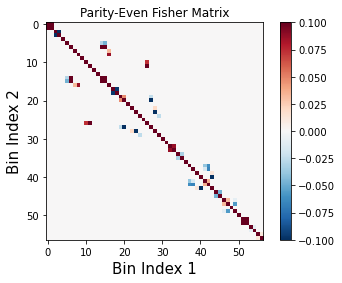

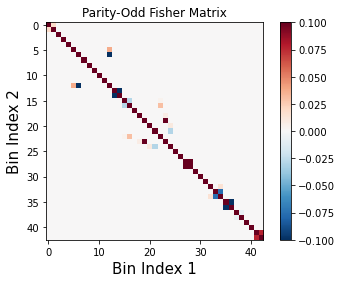

In [32]:
for fish_plot,name in zip([tspec.fish_ideal_even, tspec.fish_ideal_odd],['Even','Odd']):
    corr = fish_plot/np.sqrt(np.outer(np.diag(fish_plot),np.diag(fish_plot)))
    plt.figure()
    plt.title(r'Parity-%s Fisher Matrix'%name)
    v = 0.1
    plt.imshow(corr,vmax=v,vmin=-v,cmap=cm.RdBu_r)
    plt.xlabel(r'Bin Index 1',fontsize=15)
    plt.ylabel(r'Bin Index 2',fontsize=15)
    plt.colorbar();

As expected, these are not quite diagonal! This occurs since there are two choices of tetrahedron diagonal, so the same shape contributes to multiple bins.

### Window-free estimator
Computing the window-free trispectrum proceeds similarly to the bispectrum, and once again requires a Fisher matrix that can be computed internally or externally.

Here, we require a set of pairs of simulations to form the 2- and 0-field terms in the trispectrum estimator (i.e. those involving $aa\langle{aa\rangle}$ and $\langle{aa\rangle}\langle{aa\rangle}$). As before, these can be generated by the code or read-in from some external source. They should have the same covariance (i.e. two-point) function as the data, but can differ for higher-point functions.

Let's start by computing the Fisher matrix using 4 CPUs and then the full trispectrum. We'll compute quantities for both parities simulatenously. This might take a while...

In [33]:
# Generate MC simulations for estimator numerator
# We've used more MC iterations here than before, since the parity-even trispectrum needs an accurate two-point term
tspec.generate_sims(5*N_it//2,verb=True)

# # Alternatively, read-in pairs of MC simulations created externally
# alpha_sims = []
# for ii in range(5*N_it//2):
#     alpha1 = base.generate_data(seed=10000+ii)
#     alpha2 = base.generate_data(seed=20000+ii)
#     alpha_sims.append([alpha1,alpha2])
# tspec.load_sims(alpha_sims, verb=True)

Using 25 pairs of Monte Carlo simulations
Generating bias simulation 1 of 25
Generating bias simulation 6 of 25
Generating bias simulation 11 of 25
Generating bias simulation 16 of 25
Generating bias simulation 21 of 25


In [34]:
# Compute the Fisher matrix, via multiprocessing
fish = tspec.compute_fisher(N_it, parity='both', N_cpus=4, verb=True)

Computing Fisher contribution from 10 pairs of Monte Carlo simulations on 4 threads

Generating data

  0%|          | 0/10 [00:00<?, ?it/s]


Generating data
Generating data
Generating data




Creating H maps for S-inverse-weighted fields

Creating H maps for S-inverse-weighted fields
Creating H maps for S-inverse-weighted fields


Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weig

 10%|█         | 1/10 [05:44<51:42, 344.77s/it]


Generating data
On bin 51 of 57
On bin 41 of 57

Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
On bin 41 of 57
On bin 46 of 57
On bin 56 of 57


 20%|██        | 2/10 [05:51<19:27, 145.93s/it]


Generating data

Creating H maps for S-inverse-weighted fields
On bin 46 of 57
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
On bin 51 of 57
On bin 51 of 57
Computing raw Q maps for S-inverse-weighted fields
On bin 56 of 57

Generating data


 30%|███       | 3/10 [06:09<10:12, 87.44s/it] 


Creating H maps for S-inverse-weighted fields
On bin 56 of 57
Computing A[u1,u2] maps for S-inverse-weighted fields


 40%|████      | 4/10 [06:14<05:28, 54.81s/it]


Generating data

Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Computing raw Q maps for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields
Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing raw Q maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields
Computing raw Q map

 50%|█████     | 5/10 [11:47<12:56, 155.23s/it]


Generating data


Creating H maps for S-inverse-weighted fields
On bin 56 of 57
Computing A[u1,u2] maps for S-inverse-weighted fields
On bin 51 of 57


 60%|██████    | 6/10 [11:50<06:53, 103.45s/it]


Generating data

Creating H maps for S-inverse-weighted fields
Computing A[u1,u2] maps for S-inverse-weighted fields
On bin 46 of 57
On bin 56 of 57
Computing raw Q maps for S-inverse-weighted fields
On bin 51 of 57


 70%|███████   | 7/10 [12:01<03:39, 73.12s/it] 

Computing raw Q maps for S-inverse-weighted fields
On bin 56 of 57


 80%|████████  | 8/10 [12:06<01:43, 51.50s/it]

Assembling Q filters for S-inverse-weighted fields
Assembling Q filters for S-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields

Creating H maps for U-inverse-weighted fields
Computing A[u1,u2] maps for U-inverse-weighted fields
Computing raw Q maps for U-inverse-weighted fields
Computing raw Q maps for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields
Assembling Q filters for U-inverse-weighted fields

Computing Fisher matrix contribution
On bin 1 of 57
On bin 6 of 57
On bin 11 of 57

Computing Fisher matrix contribution
On bin 1 of 57
On bin 16 of 57
On bin 6 of 57
On bin 21 of 57
On bin 11 of 57
On bin 26 of 57
On bin 16 of 57
On bin 31 of 57
On bin 21 of 57
On bin 36 of 57
On bin 26 of 57
On bin 41 of 57
On bin 31 of 57
On bin 46 of 57
On bin 36 of 57
On bin 51 of 57
On bin 41 of 57
On bin 56 of 57


 90%|█████████ | 9/10 [14:35<01:22, 82.09s/it]

On bin 46 of 57
On bin 51 of 57
On bin 56 of 57


100%|██████████| 10/10 [14:42<00:00, 88.25s/it]


In [35]:
# Compute the unwindowed estimator, optionally removing disconnected contributions (2- and 0-field terms)
tl_unwindowed = tspec.Tl_unwindowed(data, parity='both', verb=True, include_disconnected_term=True)

Computing t0 term
Computing t0 term
Computing H^+- maps
Computing A maps
Computing A maps for cross-spectra
Assembling parity-even trispectrum numerator
Assembling parity-odd trispectrum numerator


As before, we can also compute the Fisher matrix externally (e.g., on a cluster) and read it in.

In [36]:
# # Iterate by hand
# fish = 0.
# for i in range(N_it):
#     if i%5==0: print("On iteration %d of %d"%(i+1,N_it))
#     fish += tspec.compute_fisher_contribution(i, 'both', verb=(i==0))/N_it

# # Compute unwindowed estimator, passing the Fisher matrix
# tl_unwindowed = tspec.Tl_unwindowed(data, parity='both', verb=True, fish=fish, include_disconnected_term=True)

Now we can plot!

Once again, trispectra are messy to visualize, so we'll collapse all the data into one dimension and plot directly As before, we'll compare the results from the two estimators, as well as the Fisher matrix. Let's start with the trispectra themselves:

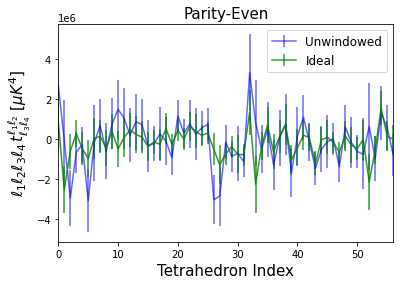

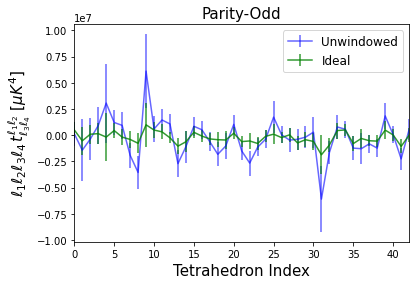

In [37]:
# Parity-Even
weights = np.asarray(l1s)*np.asarray(l2s)*np.asarray(l3s)*np.asarray(l4s)*1e24
plt.figure()
plt.title('Parity-Even',fontsize=15)
fish_err = np.sqrt(np.diag(np.linalg.inv(tspec.fish_even)))
fish_err_ideal = np.sqrt(np.diag(np.linalg.inv(tspec.fish_ideal_even))*np.mean(mask**8.)/np.mean(mask**4)**2)
plt.errorbar(np.arange(tspec.N_t_even),weights*tl_unwindowed[0],yerr=weights*fish_err,label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(np.arange(tspec.N_t_even),weights*tl_ideal_even,yerr=weights*fish_err_ideal,label='Ideal',c='g',alpha=0.8)
plt.legend(fontsize=12)
plt.xlim([0,tspec.N_t_even-1])
plt.xlabel("Tetrahedron Index",fontsize=15)
plt.ylabel(r"$\ell_1\ell_2\ell_3\ell_4\,t^{\ell_1\ell_2}_{\ell_3\ell_4}\,\,[\mu K^4]$",fontsize=15);

# Parity-Odd
weights = (np.asarray(l1s)*np.asarray(l2s)*np.asarray(l3s)*np.asarray(l4s)*1e24)[np.asarray(parities)=='both']
plt.figure()
plt.title('Parity-Odd',fontsize=15)
fish_err = np.sqrt(np.diag(np.linalg.inv(tspec.fish_odd)))
fish_err_ideal = np.sqrt(np.diag(np.linalg.inv(tspec.fish_ideal_odd))*np.mean(mask**8.)/np.mean(mask**4)**2)
plt.errorbar(np.arange(tspec.N_t_odd),weights*tl_unwindowed[1],yerr=weights*fish_err,label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(np.arange(tspec.N_t_odd),weights*tl_ideal_odd,yerr=weights*fish_err_ideal,label='Ideal',c='g',alpha=0.8)
plt.legend(fontsize=12)
plt.xlim([0,tspec.N_t_odd-1])
plt.xlabel("Tetrahedron Index",fontsize=15)
plt.ylabel(r"$\ell_1\ell_2\ell_3\ell_4\,t^{\ell_1\ell_2}_{\ell_3\ell_4}\,\,[\mu K^4]$",fontsize=15);

These look reasonable. Note that using too few simulations for the disconnected contributions (those loaded in ```generate_sims``` or ```load_sims```) can increase the variance of the estimator and cause differences between the ideal and unwindowed estimator, even with a uniform mask.

Let's look at the Fisher matrix:

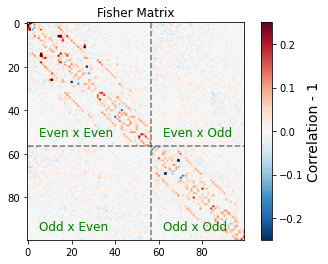

In [38]:
ff = np.linalg.inv(np.linalg.inv(tspec.fish_both)@tspec.fish_both@np.linalg.inv(tspec.fish_both)).T
corr_fish_t = ff/np.sqrt(np.outer(np.diag(ff),np.diag(ff)))
v = 0.25
plt.imshow(corr_fish_t-np.eye(len(corr_fish_t)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Fisher Matrix")
cbar = plt.colorbar();
cbar.set_label('Correlation - 1',fontsize=14)
plt.hlines(tspec.N_t_even-0.5,0.,tspec.N_t_even+tspec.N_t_odd,color='k',alpha=0.5,ls='--')
plt.vlines(tspec.N_t_even-0.5,0,tspec.N_t_even+tspec.N_t_odd,color='k',alpha=0.5,ls='--')
plt.xlim(-0.5,tspec.N_t_even+tspec.N_t_odd-0.5)
plt.ylim(tspec.N_t_even+tspec.N_t_odd-0.5,-0.5)
plt.text(5,tspec.N_t_even-5,'Even x Even',c='g',fontsize=12)
plt.text(tspec.N_t_even+5,tspec.N_t_even-5,'Even x Odd',c='g',fontsize=12)
plt.text(5,tspec.N_t_even+tspec.N_t_odd-5,'Odd x Even',c='g',fontsize=12)
plt.text(tspec.N_t_even+5,tspec.N_t_even+tspec.N_t_odd-5,'Odd x Odd',c='g',fontsize=12);

### Iterate over multiple data-sets

Just as before, we can test the estimator covariances with some mock data. This remains (comparatively) cheap, since we don't need to reload Monte Carlo simulations or recompute the Fisher matrix.

In [39]:
tl_unwindowed_all = []
tl_ideal_all = []

for jj in range(N_sim):
    
    if jj%10==0: 
        print("Analyzing simulation %d of %d"%(jj+1,N_sim))

    # Generate unmasked data
    data = mask*base.generate_data(jj,add_B=False)

    tl_ideal_all.append(tspec.Tl_ideal(data, parity='both', verb=False))
    tl_unwindowed_all.append(tspec.Tl_unwindowed(data, parity='both', verb=False))

Analyzing simulation 1 of 50
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Analyzing simulation 11 of 50
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Analyzing simulation 21 of 50
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomputed Fisher matrix
Using precomput

Below, we plot the parity-even and parity-odd components, averaged over the realizations. As expected, the results are consistent with zero. Moreover, the variance of the unwindowed estimators is close to the Fisher matrix, showing that things are close to optimal. As before, the ideal estimators seem to have lower variance; this is due to the correlations between adjacent bins, and does not lead to increased signal-to-noise.

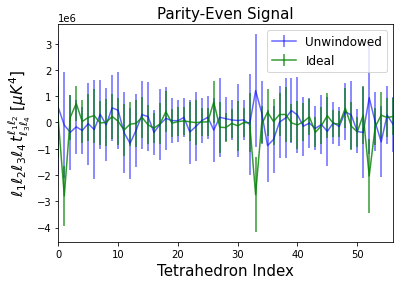

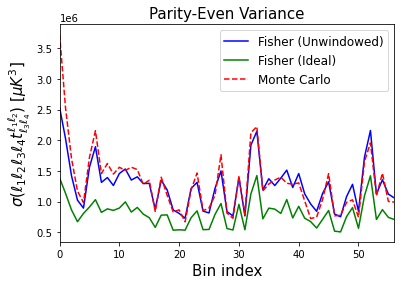

In [71]:
# Parity-Even
weights = np.asarray(l1s)*np.asarray(l2s)*np.asarray(l3s)*np.asarray(l4s)*1e24

mean_unwindowed = np.mean([tl[0] for tl in tl_unwindowed_all],axis=0)
mean_ideal = np.mean([tl[0] for tl in tl_ideal_all],axis=0)
std_unwindowed = np.std([tl[0] for tl in tl_unwindowed_all],axis=0)

plt.figure()
plt.title('Parity-Even Signal',fontsize=15)
fish_err = np.sqrt(np.diag(np.linalg.inv(tspec.fish_even)))
fish_err_ideal = np.sqrt(np.diag(np.linalg.inv(tspec.fish_ideal_even))*np.mean(mask**8.)/np.mean(mask**4)**2)
plt.errorbar(np.arange(tspec.N_t_even),weights*mean_unwindowed,yerr=weights*fish_err,label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(np.arange(tspec.N_t_even),weights*mean_ideal,yerr=weights*fish_err_ideal,label='Ideal',c='g',alpha=0.8)
plt.legend(fontsize=12)
plt.xlim([0,tspec.N_t_even-1])
plt.xlabel("Tetrahedron Index",fontsize=15)
plt.ylabel(r"$\ell_1\ell_2\ell_3\ell_4\,t^{\ell_1\ell_2}_{\ell_3\ell_4}\,\,[\mu K^4]$",fontsize=15);

plt.figure()
plt.title('Parity-Even Variance',fontsize=15)
plt.plot(np.arange(tspec.N_t_even),weights*fish_err,label='Fisher (Unwindowed)',c='b')
plt.plot(np.arange(tspec.N_t_even),weights*fish_err_ideal,label=r'Fisher (Ideal)',c='g')
plt.plot(np.arange(tspec.N_t_even),weights*std_unwindowed,label='Monte Carlo',c='r',ls='--')
plt.xlabel(r'Bin index',fontsize=15)
plt.xlim([0,tspec.N_t_even-1])
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\ell_1\ell_2\ell_3\ell_4t^{\ell_1\ell_2}_{\ell_3\ell_4})\,\,[\mu K^3]$',fontsize=15);

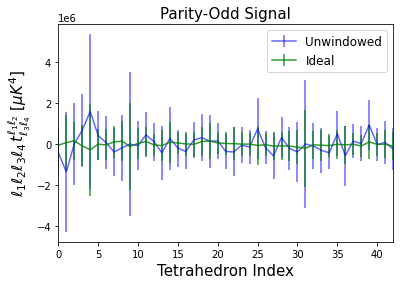

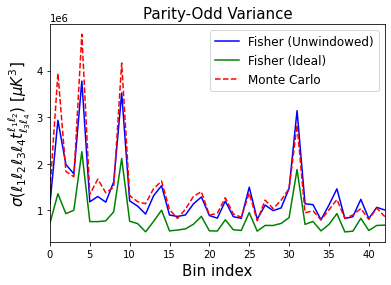

In [73]:
# Parity-Odd
weights = (np.asarray(l1s)*np.asarray(l2s)*np.asarray(l3s)*np.asarray(l4s)*1e24)[np.asarray(parities)=='both']
mean_unwindowed = np.mean([tl[1] for tl in tl_unwindowed_all],axis=0)
mean_ideal = np.mean([tl[1] for tl in tl_ideal_all],axis=0)
std_unwindowed = np.std([tl[1] for tl in tl_unwindowed_all],axis=0)

plt.figure()
plt.title('Parity-Odd Signal',fontsize=15)
fish_err = np.sqrt(np.diag(np.linalg.inv(tspec.fish_odd)))
fish_err_ideal = np.sqrt(np.diag(np.linalg.inv(tspec.fish_ideal_odd))*np.mean(mask**8.)/np.mean(mask**4)**2)
plt.errorbar(np.arange(tspec.N_t_odd),weights*mean_unwindowed,yerr=weights*fish_err,label='Unwindowed',c='b',alpha=0.6)
plt.errorbar(np.arange(tspec.N_t_odd),weights*mean_ideal,yerr=weights*fish_err_ideal,label='Ideal',c='g',alpha=0.8)
plt.legend(fontsize=12)
plt.xlim([0,tspec.N_t_odd-1])
plt.xlabel("Tetrahedron Index",fontsize=15)
plt.ylabel(r"$\ell_1\ell_2\ell_3\ell_4\,t^{\ell_1\ell_2}_{\ell_3\ell_4}\,\,[\mu K^4]$",fontsize=15);

plt.figure()
plt.title('Parity-Odd Variance',fontsize=15)
plt.plot(np.arange(tspec.N_t_odd),weights*fish_err,label='Fisher (Unwindowed)',c='b')
plt.plot(np.arange(tspec.N_t_odd),weights*fish_err_ideal,label=r'Fisher (Ideal)',c='g')
plt.plot(np.arange(tspec.N_t_odd),weights*std_unwindowed,label='Monte Carlo',c='r',ls='--')
plt.xlabel(r'Bin index',fontsize=15)
plt.xlim([0,tspec.N_t_odd-1])
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\ell_1\ell_2\ell_3\ell_4t^{\ell_1\ell_2}_{\ell_3\ell_4})\,\,[\mu K^3]$',fontsize=15);

### This computes the tutorial! For any questions, please open a GitHub issue or contact [Oliver Philcox](ohep2@cantab.ac.uk).